**_This notebook gives a detailed overview of multiclass classification algorithm to classify the peak hour of a day given a data point._**
-  This classification will be very useful for the company to understand the customer behaviour in day and perform engagement strategy on the peak hours of engagement through push notifications or live promotions.
- Also, it helps the company to optimize live betting strategies.
- This metric is also useful for scheduling customer support and risk monitoring teams.

In [0]:
pip install shap

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached shap-0.46.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (540 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
  Using cached numba-0.61.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.8 MB)
  Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
  Using cached numpy-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
  Using cached llvmlite-0.44.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.4 MB)
  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-80a283e5-af76-4093-ae3b-6dbabfac555e
  

In [0]:
dbutils.library.restartPython()

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import numpy as np

In [0]:
df = pd.read_csv('/Workspace/Users/deepak.guru.ganesan@volvo.com/leovegas/dataset_cleaned.csv').drop(['Unnamed: 0'], axis=1)
df.sort_values(['bet_placement_hour'], inplace=True)

#### Target creation

_**_Given a data points, the goal is to predict when will be the peak betting hour for that day. This is treated as a multiclass classification problem, where the classes can range from 0-24 denoting the hour of the day._**_

In [0]:
# Find the hour with max bets for each date
df['bet_placement_hour'] = pd.to_datetime(df['bet_placement_hour'])
df['eventStartDate'] = pd.to_datetime(df['eventStartDate'])

df["bet_hour"] = df["bet_placement_hour"].dt.hour  # 0-23
df["bet_dayofweek"] = df["bet_placement_hour"].dt.weekday  # 0=Monday, 6=Sunday
df["bet_weekend"] = (df["bet_dayofweek"] >= 5).astype(int)  # 1 if Saturday/Sunday, else 0
df["bet_month"] = df["bet_placement_hour"].dt.month  # 1-12
df["bet_year"] = df["bet_placement_hour"].dt.year  # 1-12
df["bet_day"] = df["bet_placement_hour"].dt.date  # 1-31


peak_hours = df.groupby("bet_day")["number_of_bets"].idxmax()  # Get index of max bets per day
#df.loc[peak_hours, "peak_hour"] = df.loc[peak_hours, "bet_hour"]

# Create a mapping of date → peak hour
date_to_peak_hour = df.loc[peak_hours, ["bet_day", "bet_hour"]].set_index("bet_day")["bet_hour"]

# Assign peak_hour to all rows based on their date
df["peak_hour"] = df["bet_day"].map(date_to_peak_hour)

#### Create new columns

_**Here also we creare some additional column like how many bets were placed in the last three hours.**_ 

In [0]:
sum_df = df.groupby(by=["eventId","bet_placement_hour"], as_index=False)["number_of_bets"].sum()

rolling_sum_series = (
    sum_df.groupby(["eventId"])
    .rolling(on="bet_placement_hour", window="3H", min_periods=1)
    .sum()
).reset_index().drop(['level_1'],axis=1).rename(columns={"number_of_bets": "rolling_bets_3h"})

df = pd.merge(df,rolling_sum_series, on=["eventId","bet_placement_hour"], how="left")


In [0]:
df["time_until_event"] = (df["eventStartDate"] - df["bet_placement_hour"]).dt.total_seconds() / 3600  # Hours until event start
df["event_hour"] = df["eventStartDate"].dt.hour  # 0-23
df["event_dayofweek"] = df["eventStartDate"].dt.weekday  # 0=Monday, 6=Sunday
df["event_weekend"] = (df["event_dayofweek"] >= 5).astype(int)  # 1 if Saturday/Sunday, else 0

df["league_popularity"] = df.groupby("league")["number_of_bets"].transform("sum") # Popularity of league (total bets in dataset)
df["team_popularity"] = df.groupby("eventName")["number_of_bets"].transform("sum") # Team popularity (if we can extract team names from eventName)

# Turnover per bet (average amount per bet)
df["avg_bet_size"] = df["total_turn_over_EUR"] / df["number_of_bets"]
# Is the event live? (Bet placed after event started)
df["is_live_bet"] = (df["bet_placement_hour"] >= df["eventStartDate"]).astype(int)
df.drop(columns=["bet_placement_hour", "eventStartDate"], inplace=True)

<AxesSubplot:>

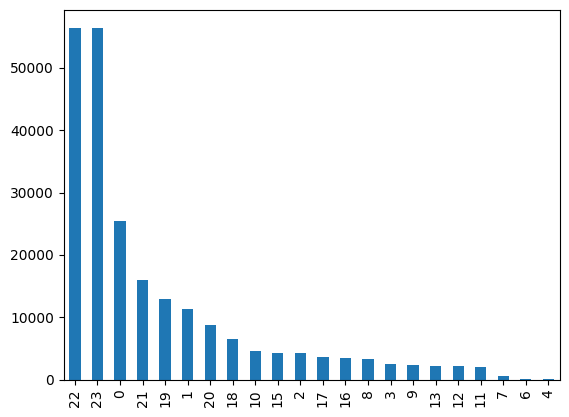

In [0]:
df['peak_hour'].value_counts().plot(kind="bar")

### Label Encoding

**_We are encoding all the categorical and string columns here before using them on the Machine learning models_**

In [0]:
# List of categorical columns
cat_columns = ["league", "event_country", "eventName","peak_hour"]

# Apply label encoding
label_encoders = {}  # Store encoders for future use
for col in cat_columns:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col].astype(str))  # Ensure strings
    label_encoders[col] = le  # Save encoder for later (e.g., if using test data)

df.drop(["league", "event_country", "eventName",'peak_hour'],axis= 1, inplace=True)
#df_test["League_encoded"] = label_encoders["League"].transform(df_test["League"].astype(str))

#### Feature Selection using Correlation Matrix

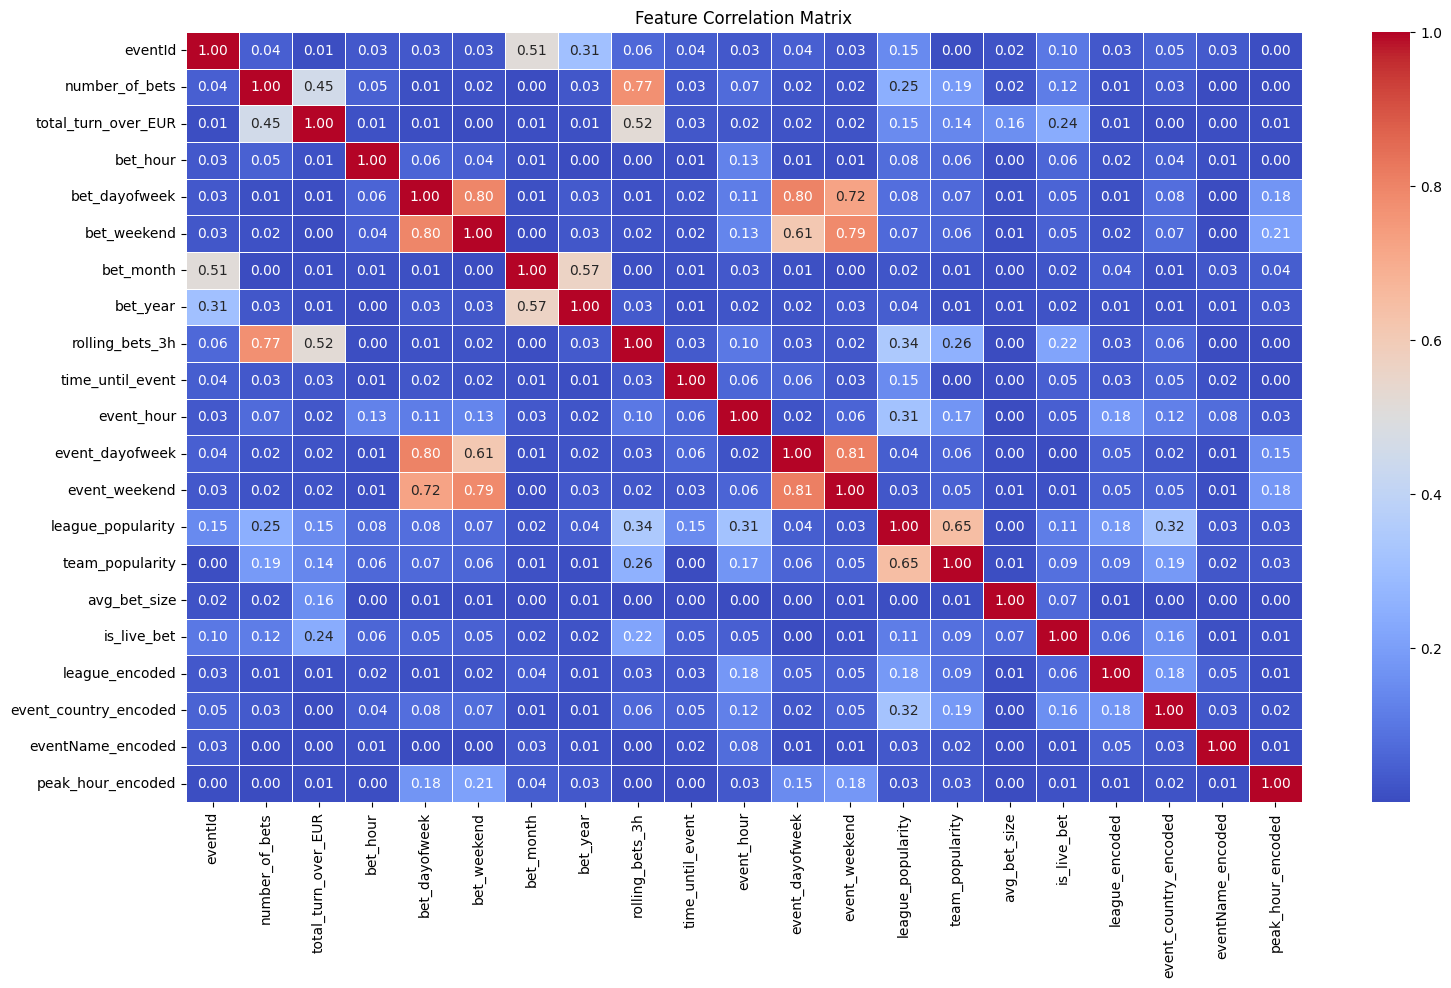

Dropped features due to high correlation: set()


In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Visualize the correlation matrix
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Select the upper triangle of the correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation > 0.9
to_drop = set()
for column in upper.columns:
    correlated_features = upper.index[upper[column] > 0.9].tolist()
    if correlated_features:
        # Keep one feature (the one with higher variance) and drop others
        keep = column  # Assume 'column' is the better feature to keep
        drop_candidates = correlated_features

        # Check variance to decide which one to drop
        if df[keep].std() < df[drop_candidates].std().max():
            keep = drop_candidates[np.argmax(df[drop_candidates].std())]  # Keep the one with max variance
            drop_candidates.append(column)  # Add original column to drop list

        to_drop.update(set(drop_candidates) - {keep})  # Drop all except 'keep'

#Drop selected features
df.drop(columns=to_drop, inplace=True)
print(f"Dropped features due to high correlation: {to_drop}")


##### Feature Importance using SHAP

**_We are now performing feature importance using ShapeLy and ignoring the least impacting features for our peak hour classification algorithm_**

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X = df.drop(columns=["bet_day","peak_hour_encoded"])
y = df["peak_hour_encoded"]  # Target is the peak hour (0-23)
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
xgb_model = XGBClassifier(objective="multi:softprob", num_class=len(y.unique()), eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=22, num_parallel_tree=None, objective='multi:softprob', ...)

In [0]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)  # SHAP values for each class

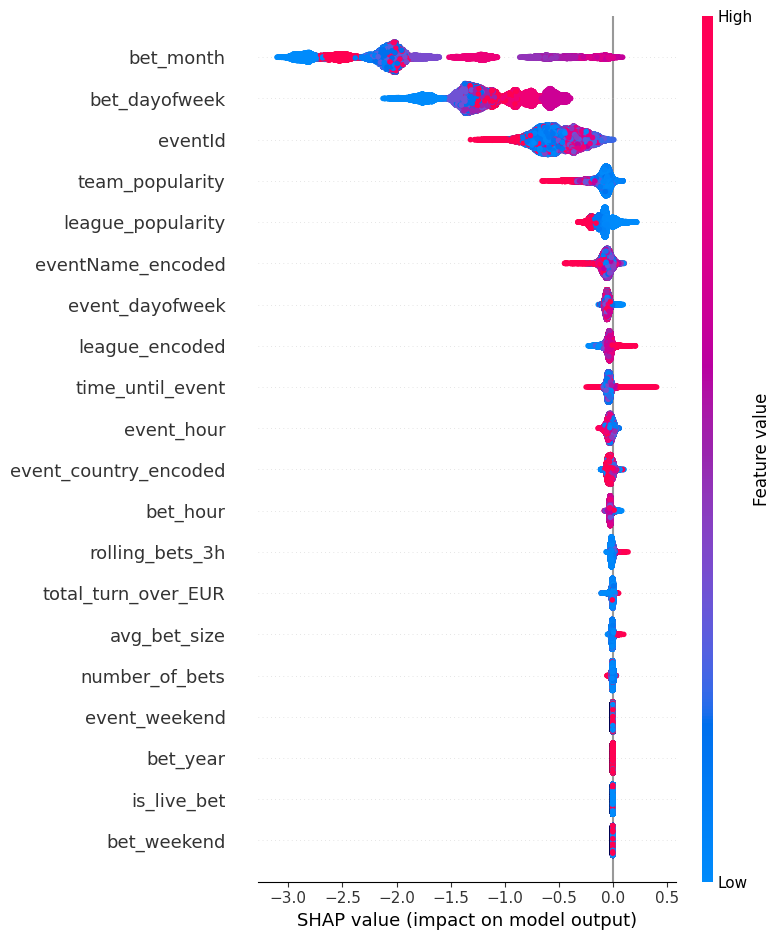

In [0]:
mean_shap_values = np.mean(shap_values, axis=2)  # Shape will be (45791, 20)
shap.summary_plot(mean_shap_values, X_test)

**_This graph shows if a particular feature has a positive or negative impact in the classification and also how much is that impact. 0 means no impact. And each point he
re is each data point._** 

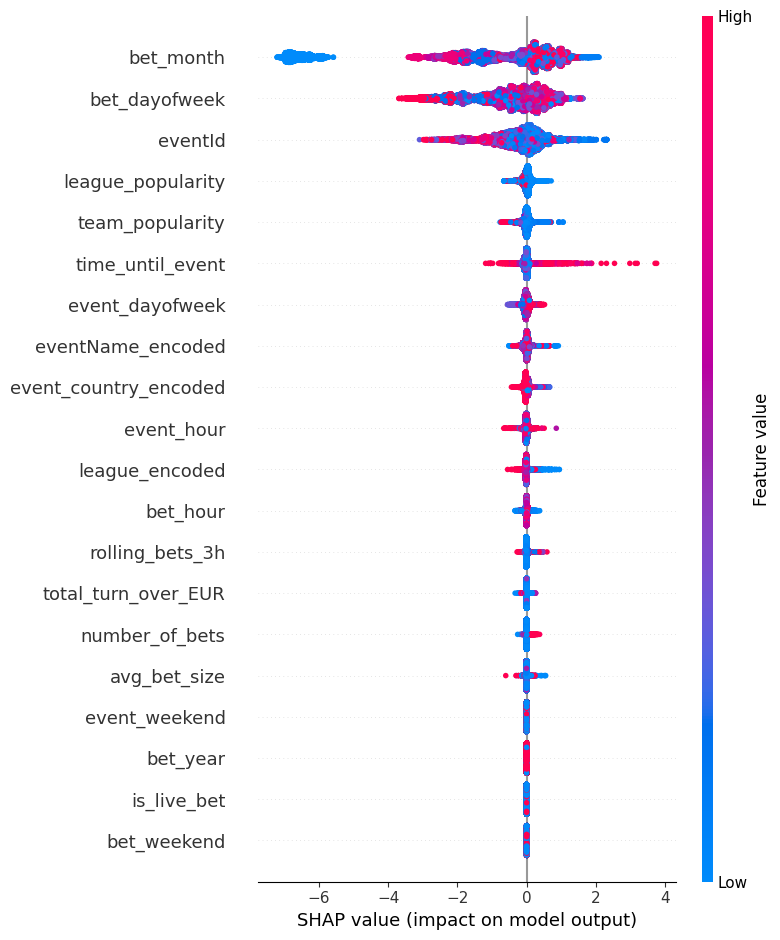

In [0]:
class_index = 0 

# Extracting SHAP values for the specific class 0
shap_values_for_class = shap_values[:, :, class_index]  # Shape will be (45791, 20)

# Create a summary plot for the selected class
shap.summary_plot(shap_values_for_class, X_test)

In [0]:
import numpy as np
import pandas as pd

feature_importance = np.mean(np.abs(shap_values), axis=(0, 2))  # Shape will be (20,)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,  # Assuming X_test is a DataFrame with feature names
    "SHAP Importance": feature_importance
}).sort_values(by="SHAP Importance", ascending=False)

# Drop features below threshold (e.g., SHAP < 0.01)
threshold = 0.01
selected_features = feature_importance_df[feature_importance_df["SHAP Importance"] > threshold]["Feature"].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


**_We have sorted each feature based on its importance according, and removed all the features which has the importance score of less than 0.01_**

In [0]:
feature_importance_df

,Feature,SHAP Importance
6,bet_month,2.278313
4,bet_dayofweek,1.368500
0,eventId,0.707107
14,team_popularity,0.206147
13,league_popularity,0.161593
19,eventName_encoded,0.142426
11,event_dayofweek,0.098998
17,league_encoded,0.087567
10,event_hour,0.086548
9,time_until_event,0.070322


**_Retraining the model with selected features and classifying the peak hours._**

In [0]:
xgb_model.fit(X_train_selected, y_train)
y_pred = xgb_model.predict(X_test_selected)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=22, num_parallel_tree=None, objective='multi:softprob', ...)

#### Evaluation Metrics for the classification

**_I have shown various evaluation metrics like Precision, Accuracy, F1 Score and Recall. Also, I have created a confusion matrix pertaining each label and shown how well it has classified the results._**

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print('-----------------------------------------------------------------------------')
# Precision
precision = precision_score(y_test, y_pred, average=None)
print(f"Precision: {precision}")
print('-----------------------------------------------------------------------------')

# Recall
recall = recall_score(y_test, y_pred, average=None)
print(f"Recall: {recall}")
print('-----------------------------------------------------------------------------')

# F1 score
f1 = f1_score(y_test, y_pred, average=None)
print(f"F1 score: {f1}")
print('-----------------------------------------------------------------------------')


Classification Accuracy: 0.87
-----------------------------------------------------------------------------
Precision: [0.85746794 0.91938883 0.91620112 0.95744681 0.91273585 0.85557987
 0.85960875 0.91730475 0.93986014 0.92536116 0.86205564 0.92703349
 0.87826603 0.84989993 0.85304566 0.85075764 0.85929648 1.
 1.         0.96116505 0.93970588 0.91806723]
-----------------------------------------------------------------------------
Recall: [0.81981804 0.79789666 0.91111111 0.96889952 0.9020979  0.90092166
 0.90765492 0.86937591 0.91056911 0.90502355 0.86506398 0.91283863
 0.86188811 0.80277253 0.86110382 0.89214381 0.97343454 1.
 1.         0.96116505 0.9652568  0.92194093]
-----------------------------------------------------------------------------
F1 score: [0.83822042 0.85434517 0.91364903 0.96313912 0.9073857  0.87766554
 0.88297872 0.89269747 0.92498279 0.91507937 0.86355719 0.91988131
 0.87       0.82566429 0.8570558  0.87095936 0.91281139 1.
 1.         0.96116505 0.95230999 0.

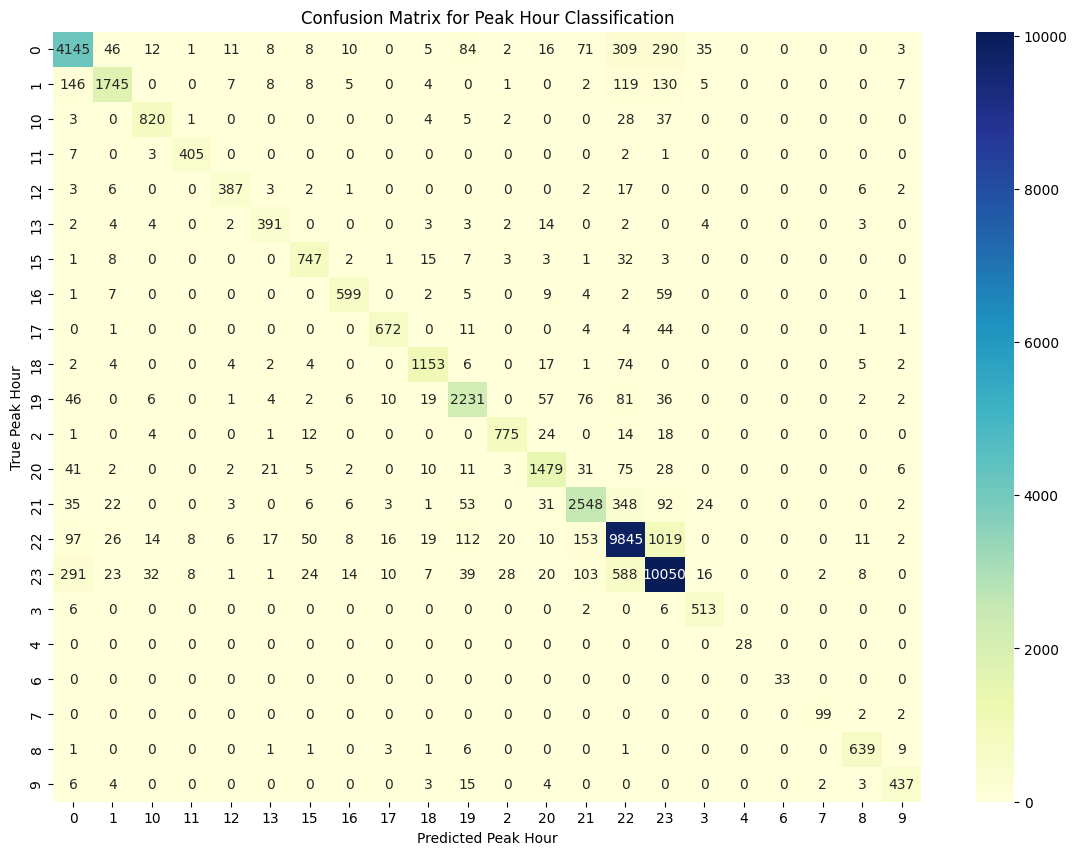

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_test_actual = le.inverse_transform(y_test)
y_pred_actual = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test_actual, y_pred_actual)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=sorted(set(y_test_actual)), yticklabels=sorted(set(y_test_actual)))
plt.xlabel("Predicted Peak Hour")
plt.ylabel("True Peak Hour")
plt.title("Confusion Matrix for Peak Hour Classification")
plt.show()